### Numba code working for the underdamped case



In [4]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)


import time as time

# -------------- SET UP YOUR PATH ------------
import sys
sys.path.append("~/OneDrive/ExtendedProject/Code/Weak SDE approximation/C++")

import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# function to plot numba results 
def plot_qpnumba(qp,tau,gamma):
    fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(25,8))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    fig.suptitle("$\\tau$="+str(tau)+", $\\gamma=$"+str(gamma)+", $N=$"+str(len(qp[::,0])))

    #Plot 1
    ## position q experiment
    histogram,bins = np.histogram(qp[::,0],bins=100,range=[0,1.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx_q,histogram,label='q-Experiment')
    ax1.legend() 

    #Plot 2: 
    ### momentum p experiment
    histogram,bins = np.histogram(qp[::,1],bins=100,range=[-1.5,1.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    # histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
    ax2.plot(midx_p,histogram,label='p-Experiment')

    ### position q true
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    ax1.plot(midx_q,rho,'--',label='Truth')
    ax1.legend() 

    ### momentum p true
    rho = np.exp(- (midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    ax2.plot(midx_p,rho,'--',label='Truth')
    ax2.legend() 

    #Plot 3 
    ax3.set_ylim(-5,5)
    ax3.plot(qp[::,1],label="p")
    ax3.plot(qp[::,0],label="q")



    ax3.legend()


## Write adaptive code that saves values at each time

The general idea we use to create a bounded function is : 
$$
g(x) = \frac{1}{\frac{1}{M}+\frac{1}{\sqrt{g^2+m^2}}}
$$
and 
$$
g'(x) = \frac{M^2g(x)g'(x)}{\left(\sqrt{g^2(x)+m^2}+M^2\right)\sqrt{g^2(x)+m^2}}
$$

The hessian, as suggested by Jonas, would be for a potential: 
$$
U(x) = \frac{1}{2 x^2} + x^2
$$
and derivative is 
$$
U'(x) = -\frac{1}{x^3} + 2*x
$$
To simplify the function $g(x)$, we only consider the part that is difficult to integrate ($1/x^2$), so we have 
$$
U_2'(x) = -\frac{1}{x^3}
$$
and 
$$
U_2''(x) = \frac{3}{x^4}.
$$

The function we seek to bound is therefore: $g(x) = \frac{x^4}{3}$, and we have that $g'(x) = \frac{4}{3} x^3 $, $g^2(x) =  \frac{x^8}{9}$. The function we will use are therefore: 
$$
g(x) = \frac{1}{\frac{1}{M}+\frac{1}{\sqrt{x^8/9+m^2}}}
$$
and 
$$
g'(x) = \frac{M^2 4/3 x^3 x^4/3 }{\left(\sqrt{x^8/9+m^2}+M^2\right)\sqrt{x^8/9+m^2}} \\
\Leftrightarrow  g'(x) = \frac{M^2 4/9 x^7 }{\left(\sqrt{x^8/9+m^2}+M^2\right)\sqrt{x^8/9+m^2}}

$$



In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32, boolean
import numba as nb
import time as time
##############################
# Define some global variables
##############################
M=1
m=0.001
# include_hessian=False # if 1 include divergence term
# include_ada=True
printskip=200

def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res


# * Using the first derivative   *#
###################################
@njit(float64(float64))
def getg(x):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    return gprime

# * Using the hessian definition *#
###################################
@njit(float64(float64))
def getg_hessian(x): #,dtmin, dtmax, R):
    gi2 = np.power(x,8)/9
    xi = np.sqrt(m*m+gi2)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime_hessian(x):
    gi2 = np.power(x,8)/9
    xi = np.sqrt(gi2+m*m)
    x7=gi2/x*4
    Mxi =np.power((M+xi),2)
    gprime= x7*M*M/(Mxi*xi)
    return gprime

 # * Using the definition of one trajectory *#
##############################################  
@njit(float64[:,:](float64[:],float64,float64,float64,float64,boolean,boolean))
def one_traj_ada(qp,Nt,dt,gamma,tau,include_hessian, include_ada):
    t=0
    q=qp[0]
    p=qp[1]

    #useful things to compute for first step
    f = -Up(q)

    #choose definition of g we prefer 
    g=1
    gp=0
    if include_ada==True:
        if include_hessian==True:
            g=getg_hessian(q)
            gp=getgprime_hessian(q)
        else: 
            g=getg(q)
            gp=getgprime(q)
    gdt=g*dt

    #set up vectors to save results 
    size_save = int(Nt/printskip)
    tqpg_list = np.zeros((size_save,4))
    save_i=0 

    for count in range(Nt):
        #**********
        #* STEP B *
        #**********
        p +=0.5*(gdt*f+dt*tau*gp)

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP O *
        #**********
        dB = np.random.normal(0,1)
        C =np.exp(-gdt*gamma) 
        p = C*p+ np.sqrt((1-C*C)*tau)*dB

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP B *
        #**********
        # Need to compute new quantities for f and g 
        f = -Up(q)
        g=1
        gp=0
        if include_ada==True:
            if include_hessian==True:
                g=getg_hessian(q)
                gp=getgprime_hessian(q)
            else: 
                g=getg(q)
                gp=getgprime(q)
        gdt=g*dt

        p +=0.5*(gdt*f+dt*tau*gp)
     

        #*********************************
        #* Save (p,q) and update time and*
        #*********************************
        if count%printskip==0:
            tqpg_list[save_i,0]=count
            tqpg_list[save_i,1]=q
            tqpg_list[save_i,2]=p
            tqpg_list[save_i,3]=g

            save_i+=1

        t+= dt 
    return(tqpg_list)

@njit(parallel=True)
def method_baoab_ada(n_samples,gamma,tau,Nt,h,include_hessian, include_ada):
    nsample_pertraj = int(Nt/printskip)
    tqpg_list=np.zeros((n_samples*nsample_pertraj,5))
    ones_nsample=np.ones(nsample_pertraj)
    qipi = np.array([2.0,0.0]) #np.random.normal(0,1,2) #initial conditions
    for j in nb.prange(n_samples):
        qp_samples = one_traj_ada(qipi,Nt,h,gamma,tau,include_hessian, include_ada)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        tqpg_list[start_i:end_i,1:5]=qp_samples
        tqpg_list[start_i:end_i,0]=ones_nsample*j
    return(tqpg_list)

#compile the method
qp = method_baoab_ada(2,0.1,0.1,10,0.1,False,False)

### Run the code for a set of parameters with adaptivity turned on

In [8]:
# T=200
# h = 0.1
# gamma = 0.1
# tau=1
# n_samples=500000

T=600
h = 0.1
gamma = 0.1
tau=0.1
n_samples=100000

Ntimes=int(T*1/h)

# * Compute sol with g(x)=1/v'(X)
# include_hessian, include_ada = False, True
# qp_ada = method_baoab_ada(n_samples,gamma,tau,Ntimes,h,include_hessian, include_ada)


In [143]:
np.savetxt("qp_ada",qp_ada)

In [144]:
del qp_ada

In [145]:
# * Compute sol with g(x)=1/v''(X)
include_hessian, include_ada = True, True
qp_ada_hessian = method_baoab_ada(n_samples,gamma,tau,Ntimes,h,include_hessian, include_ada)


In [146]:
np.savetxt("qp_ada_hessian",qp_ada_hessian)


In [147]:
del qp_ada_hessian

In [9]:
# * Compute non adaptive sol for solution
include_hessian, include_ada = False, False
h=0.0001
T=100
Ntimes=int(T*1/h)
qp_no_ada = method_baoab_ada(n_samples,gamma,tau,Ntimes,h,include_hessian, include_ada)


: 

: 

In [149]:
np.savetxt("qp_no_ada",qp_no_ada)

In [150]:
del qp_no_ada

## Compare results from using different definition of function g(x) 

In [151]:
import pandas as pd
qp_ada_hessian=np.loadtxt("qp_ada_hessian")
qp_ada=np.loadtxt("qp_ada")
qp_no_ada=np.loadtxt("qp_no_ada")


In [152]:
df_ada = pd.DataFrame(qp_ada,columns=["sim","step","Q","P","g"])
df_ada_hessian = pd.DataFrame(qp_ada_hessian,columns=["sim","step","Q","P","g"])
df_no_ada = pd.DataFrame(qp_no_ada,columns=["sim","step","Q","P","g"])

In [153]:
## Get a list of 10 times 
list_step=df_ada['step'].unique()
list_step=list_step[1::2]#
print(list_step)

[ 200.  600. 1000. 1400. 1800. 2200. 2600. 3000. 3400. 3800. 4200. 4600.
 5000. 5400. 5800.]


IndexError: index 5 is out of bounds for axis 1 with size 5

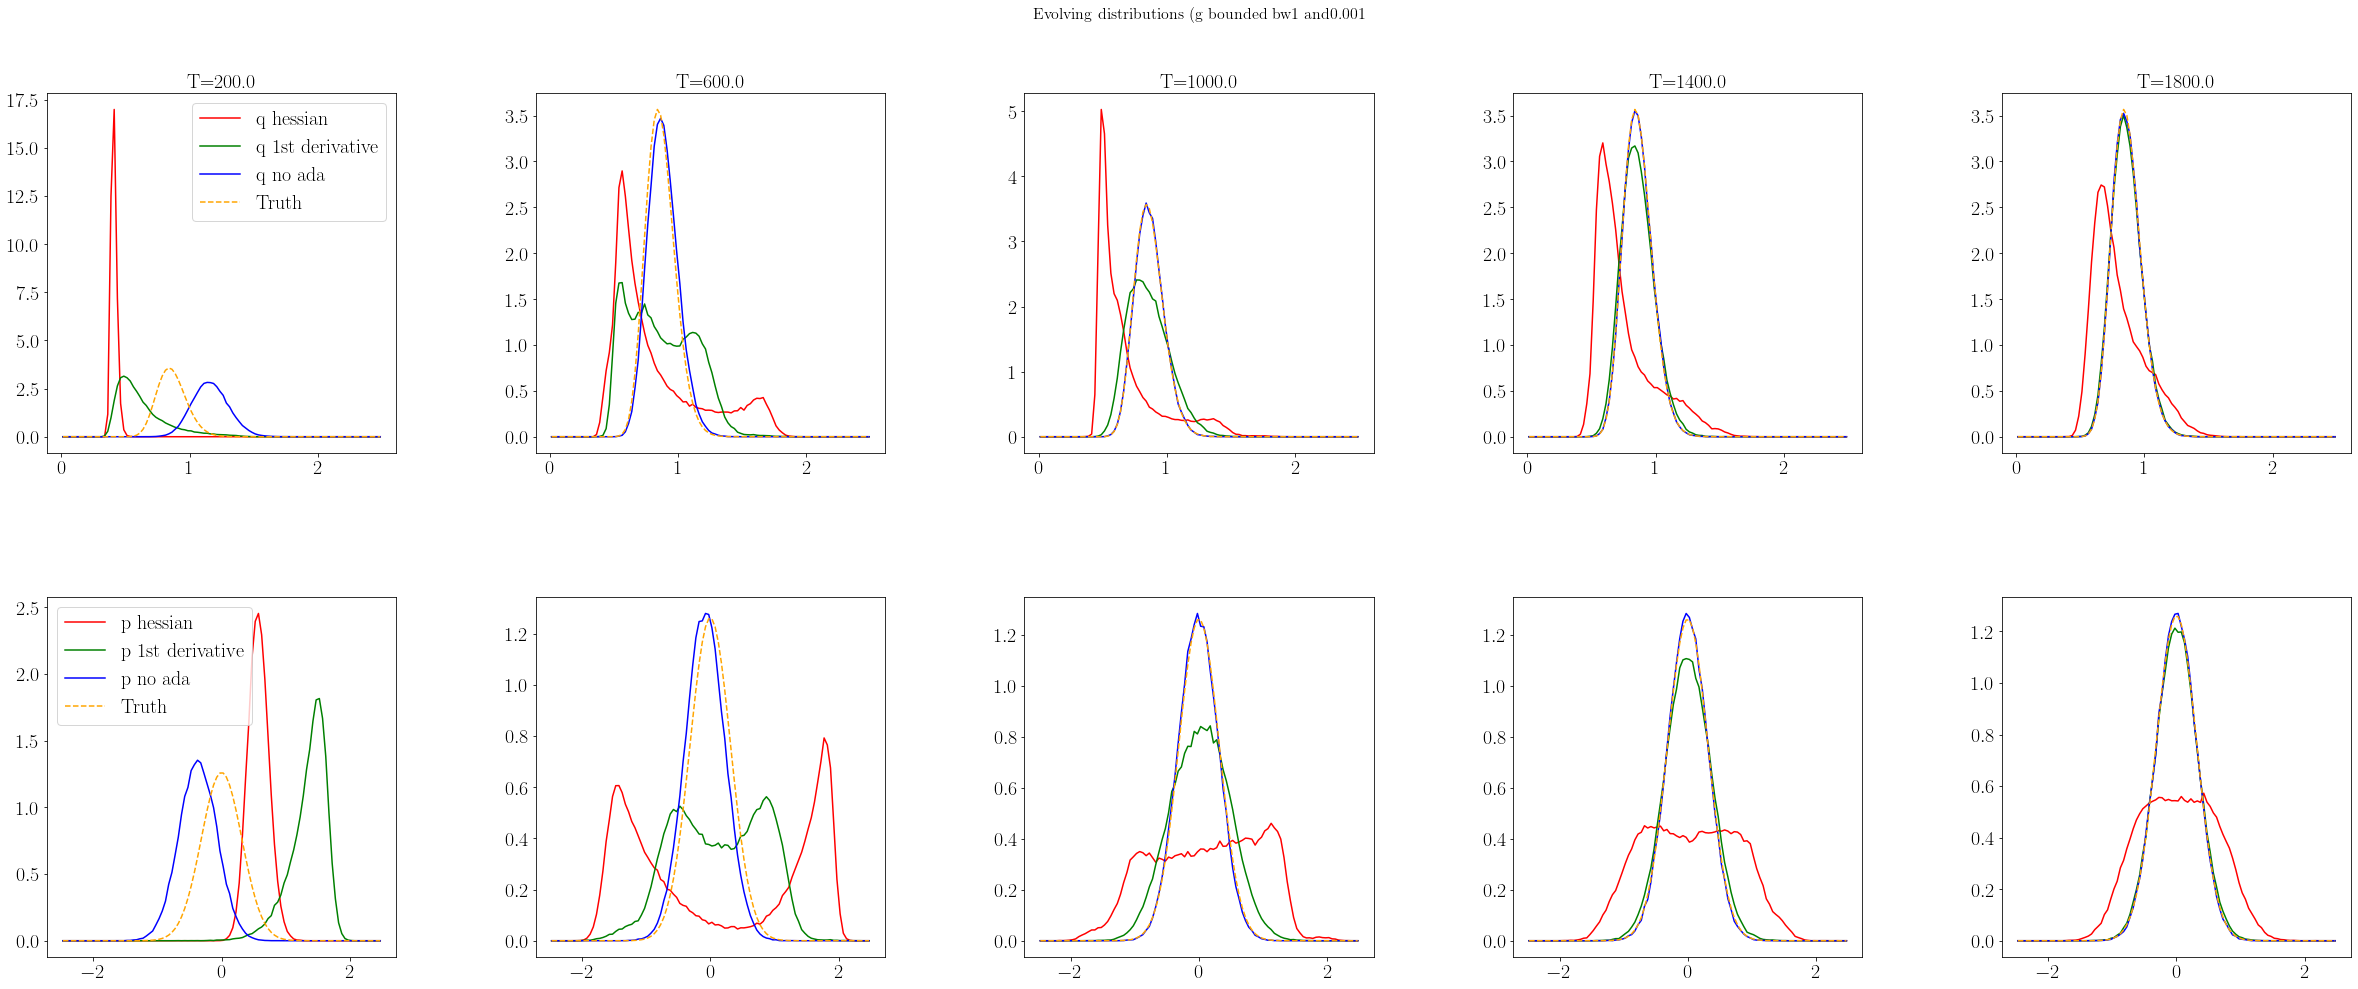

In [154]:
## Set up the plots 
fig, ((axs))= plt.subplots(2,5,figsize=(40,15))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('Evolving distributions (g bounded bw'+str(M)+' and' +str(m), fontsize=16)

## Loop through the values 
for i in range(len(list_step)):
    
    # List of time
    ti = list_step[i]
    # * Dataframe using hessian
    df_ada_hessian_i=df_ada_hessian[df_ada_hessian['step']==ti]
    # * Dataframe using first derivative 
    df_ada_i=df_ada[df_ada['step']==ti]
    # * Dataframe using no adaptivity 
    df_no_ada_i=df_no_ada[df_no_ada['step']==ti]
    
    # --- Q at time t=ti hessian
    histogram,bins = np.histogram(df_ada_hessian_i["Q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='q hessian',color="red")

    # --- Q at time t=ti first derivative
    histogram,bins = np.histogram(df_ada_i["Q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='q 1st derivative',color="green")
    # --- Q at time t=ti not adaptive
    histogram,bins = np.histogram(df_no_ada_i["Q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='q no ada',color="blue")


    # --- P at time t=ti adaptive
    histogram,bins = np.histogram(df_ada_hessian_i["P"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='p hessian',color="red")
    # --- Q at time t=ti first derivative 
    histogram,bins = np.histogram(df_ada_i["P"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='p 1st derivative',color="green")
    # --- Q at time t=ti not adaptive  
    histogram,bins = np.histogram(df_no_ada_i["P"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='p no ada',color="blue")

    # --- Q true
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    axs[0,i].plot(midx_q,rho,'--',label='Truth',color="orange")
    axs[0,i].set_title("T="+str(np.round(ti,3)))
    axs[0,0].legend() 

    # --- P true
    rho = np.exp(- (midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    axs[1,i].plot(midx_p,rho,'--',label='Truth',color="orange")
    axs[1,0].legend() 
fig.savefig('outputM'+str(M)+"m"+str(m)+"T"+str(200)+"h"+str(h)+"gamma"+str(gamma)+"tau"+str(tau)+".png")

## Change parameters 